In [101]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [102]:
df=pd.read_csv("Data/FoodBalanceSheets_E_All_Data/FoodBalanceSheets_E_All_Data_NOFLAG.csv", encoding="latin-1")

In [103]:
df.drop(["Area Code","Item Code","Element Code"],axis=1,inplace=True)
df

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,Afghanistan,Population,Total Population - Both sexes,1000 persons,29186.00,30117.00,31161.00,32270.00,33371.00,34414.00,35383.00,36296.00,37172.00,38042.00
1,Afghanistan,Population,Domestic supply quantity,1000 tonnes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Afghanistan,Grand Total,Food supply (kcal/capita/day),kcal/capita/day,2170.00,2152.00,2159.00,2196.00,2265.00,2250.00,2228.00,2303.00,2270.00,2273.00
3,Afghanistan,Grand Total,Protein supply quantity (g/capita/day),g/capita/day,59.23,58.00,57.82,57.71,60.17,58.45,58.46,59.50,57.62,57.31
4,Afghanistan,Grand Total,Fat supply quantity (g/capita/day),g/capita/day,36.69,34.81,36.53,37.10,41.48,38.28,40.70,40.03,41.46,39.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319738,Net Food Importing Developing Countries,Miscellaneous,Food,1000 tonnes,787.00,839.00,921.00,935.00,958.00,992.00,1032.00,1066.00,1140.00,1199.00
319739,Net Food Importing Developing Countries,Miscellaneous,Food supply quantity (kg/capita/yr),kg,0.62,0.65,0.68,0.67,0.67,0.68,0.69,0.70,0.73,0.75
319740,Net Food Importing Developing Countries,Miscellaneous,Food supply (kcal/capita/day),kcal/capita/day,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
319741,Net Food Importing Developing Countries,Miscellaneous,Protein supply quantity (g/capita/day),g/capita/day,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


In [104]:
df.dropna(axis=0, inplace=True)

In [105]:
df=df.loc[~(df.iloc[:,4:]==0).all(axis=1)]

In [106]:
df.Area.value_counts()

World                                      1738
Asia                                       1659
Net Food Importing Developing Countries    1604
Americas                                   1590
Africa                                     1551
                                           ... 
Vanuatu                                     537
Sao Tome and Principe                       524
Saint Kitts and Nevis                       519
Micronesia                                  461
Kiribati                                    461
Name: Area, Length: 212, dtype: int64

In [107]:
df.Item.value_counts()

Milk - Excluding Butter     5280
Eggs                        4586
Miscellaneous               3556
Cereals - Excluding Beer    3243
Oilcrops                    3075
                            ... 
Cloves                       410
Sugar non-centrifugal        321
Palm kernels                 314
Ricebran Oil                 213
Population                   212
Name: Item, Length: 119, dtype: int64

In [108]:
df.Element.unique()

array(['Total Population - Both sexes', 'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Production',
       'Import Quantity', 'Stock Variation', 'Export Quantity',
       'Domestic supply quantity', 'Feed', 'Seed', 'Losses', 'Residuals',
       'Food', 'Food supply quantity (kg/capita/yr)', 'Processing',
       'Other uses (non-food)', 'Tourist consumption'], dtype=object)

In [109]:
def select(area,item ):
    data=df[df.Area==area]
    data=data[data['Item'].str.contains(item)]
    return data

In [110]:
data=select("China","Cereals - Ex")

In [111]:
data

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
44939,China,Cereals - Excluding Beer,Production,1000 tonnes,498113.00,521383.00,541368.00,554623.00,559483.00,620074.00,616491.00,616130.00,611244.00,614914.00
44940,China,Cereals - Excluding Beer,Import Quantity,1000 tonnes,13861.00,13044.00,22636.00,22952.00,28186.00,41880.00,31380.00,35473.00,29491.00,27492.00
44941,China,Cereals - Excluding Beer,Stock Variation,1000 tonnes,8114.00,16754.00,34353.00,64549.00,75918.00,80210.00,44705.00,35028.00,7514.00,6019.00
44942,China,Cereals - Excluding Beer,Export Quantity,1000 tonnes,3127.00,2793.00,2456.00,2414.00,2029.00,1770.00,2323.00,3686.00,5683.00,7154.00
44943,China,Cereals - Excluding Beer,Domestic supply quantity,1000 tonnes,500734.00,514880.00,527195.00,510613.00,509722.00,579975.00,600843.00,612889.00,627539.00,629233.00
44944,China,Cereals - Excluding Beer,Feed,1000 tonnes,151931.00,158640.00,164114.00,151419.00,146148.00,188554.00,211366.00,219363.00,231253.00,232039.00
44945,China,Cereals - Excluding Beer,Seed,1000 tonnes,13242.00,13073.00,13167.00,12518.00,13292.00,13672.00,13576.00,13449.00,13225.00,12829.00
44946,China,Cereals - Excluding Beer,Losses,1000 tonnes,19013.00,19976.00,21105.00,21453.00,21926.00,24945.00,24365.00,24293.00,24021.00,23997.00
44947,China,Cereals - Excluding Beer,Processing,1000 tonnes,11574.00,12760.00,12688.00,13384.00,16191.00,15775.00,14741.00,14499.00,12829.00,12608.00
44948,China,Cereals - Excluding Beer,Other uses (non-food),1000 tonnes,28599.00,29694.00,32682.00,30592.00,28518.00,48065.00,49183.00,50367.00,52781.00,52100.00


In [112]:
def mean_based(year):
    try:
        mean_pred=[]
        losses=data[data.Element=="Losses"].iloc[0,4:]
        count=0
        sum=0
        for i in losses.index:
            if i=="Y"+str(year):
                break
            sum=losses[i]+sum
            count+=1
        mean_pred=sum/count
        return mean_pred
    except:
        return losses["Y"+str(year)]

In [113]:
predd=mean_based(2005)
predd

22509.4

In [114]:
mean_based_pred=[]
losses=pd.DataFrame(data[data.Element=="Losses"].iloc[0,4:])
losses.columns=["Actual"]
losses["MeanBasedPred"]=np.zeros([len(losses)])
for i in losses.index:
    losses["MeanBasedPred"][i]=mean_based(int(i[1:]))

/var/folders/t6/nkv95bj97gv9j73w9bfk2p0r0000gn/T/ipykernel_11843/3604102451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses["MeanBasedPred"][i]=mean_based(int(i[1:]))


In [115]:
int(losses.index[0][1:])

2010

In [116]:
losses["Actual"]["Y2010"]

19013.0

In [117]:
losses

,Actual,MeanBasedPred
Y2010,19013.0,19013.000000
Y2011,19976.0,19013.000000
Y2012,21105.0,19494.500000
Y2013,21453.0,20031.333333
Y2014,21926.0,20386.750000
Y2015,24945.0,20694.600000
Y2016,24365.0,21403.000000
Y2017,24293.0,21826.142857
Y2018,24021.0,22134.500000
Y2019,23997.0,22344.111111


In [118]:
population=df[df["Element"]=="Total Population - Both sexes"]
population=population[population.Area=="China"].iloc[0,4:]*1000
population

Y2010    1399503000.0
Y2011    1407325000.0
Y2012    1415164000.0
Y2013    1422971000.0
Y2014    1430671000.0
Y2015    1438193000.0
Y2016    1445524000.0
Y2017    1452626000.0
Y2018    1459378000.0
Y2019    1465634000.0
Name: 44928, dtype: object

In [119]:
data

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
44939,China,Cereals - Excluding Beer,Production,1000 tonnes,498113.00,521383.00,541368.00,554623.00,559483.00,620074.00,616491.00,616130.00,611244.00,614914.00
44940,China,Cereals - Excluding Beer,Import Quantity,1000 tonnes,13861.00,13044.00,22636.00,22952.00,28186.00,41880.00,31380.00,35473.00,29491.00,27492.00
44941,China,Cereals - Excluding Beer,Stock Variation,1000 tonnes,8114.00,16754.00,34353.00,64549.00,75918.00,80210.00,44705.00,35028.00,7514.00,6019.00
44942,China,Cereals - Excluding Beer,Export Quantity,1000 tonnes,3127.00,2793.00,2456.00,2414.00,2029.00,1770.00,2323.00,3686.00,5683.00,7154.00
44943,China,Cereals - Excluding Beer,Domestic supply quantity,1000 tonnes,500734.00,514880.00,527195.00,510613.00,509722.00,579975.00,600843.00,612889.00,627539.00,629233.00
44944,China,Cereals - Excluding Beer,Feed,1000 tonnes,151931.00,158640.00,164114.00,151419.00,146148.00,188554.00,211366.00,219363.00,231253.00,232039.00
44945,China,Cereals - Excluding Beer,Seed,1000 tonnes,13242.00,13073.00,13167.00,12518.00,13292.00,13672.00,13576.00,13449.00,13225.00,12829.00
44946,China,Cereals - Excluding Beer,Losses,1000 tonnes,19013.00,19976.00,21105.00,21453.00,21926.00,24945.00,24365.00,24293.00,24021.00,23997.00
44947,China,Cereals - Excluding Beer,Processing,1000 tonnes,11574.00,12760.00,12688.00,13384.00,16191.00,15775.00,14741.00,14499.00,12829.00,12608.00
44948,China,Cereals - Excluding Beer,Other uses (non-food),1000 tonnes,28599.00,29694.00,32682.00,30592.00,28518.00,48065.00,49183.00,50367.00,52781.00,52100.00


In [120]:
lstm_data=pd.DataFrame(population)
lstm_data.columns=["Population"]

In [121]:
lstm_data["Actual Loss"]=losses["Actual"]

# LSTM MODEL

In [122]:
lstm_data

,Population,Actual Loss
Y2010,1399503000.0,19013.0
Y2011,1407325000.0,19976.0
Y2012,1415164000.0,21105.0
Y2013,1422971000.0,21453.0
Y2014,1430671000.0,21926.0
Y2015,1438193000.0,24945.0
Y2016,1445524000.0,24365.0
Y2017,1452626000.0,24293.0
Y2018,1459378000.0,24021.0
Y2019,1465634000.0,23997.0


In [123]:
# df_for_training=lstm_data[:-3].to_numpy()
# df_for_testing=lstm_data[-3:].to_numpy()

In [124]:
# scaler = MinMaxScaler(feature_range=(0,1))
# df_for_training_scaled = scaler.fit_transform(df_for_training)
# df_for_testing_scaled=scaler.transform(df_for_testing)
# type(df_for_training_scaled)

In [125]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [126]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(lstm_data["Actual Loss"], WINDOW_SIZE)
X1.shape, y1.shape

((5, 5, 1), (5,))

In [128]:
X_train1, y_train1 = X1[:3], y1[:3]
X_val1, y_val1 = X1[3:4], y1[3:4]
X_test1, y_test1 = X1[4:], y1[4:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3, 5, 1), (3,), (1, 5, 1), (1,), (1, 5, 1), (1,))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [132]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

# model1.summary()

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 410631520.0000 - root_mean_squared_error: 20264.0449

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 410631520.0000 - root_mean_squared_error: 20264.0449 - val_loss: 353585792.0000 - val_root_mean_squared_error: 18803.8770
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 373239808.0000 - root_mean_squared_error: 19319.4160

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 373239808.0000 - root_mean_squared_error: 19319.4160 - val_loss: 315068960.0000 - val_root_mean_squared_error: 17750.1816
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 333641088.0000 - root_mean_squared_error: 18265.8457

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 4s 4s/step - loss: 333641088.0000 - root_mean_squared_error: 18265.8457 - val_loss: 275056448.0000 - val_root_mean_squared_error: 16584.8262
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 292432256.0000 - root_mean_squared_error: 17100.6504

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 292432256.0000 - root_mean_squared_error: 17100.6504 - val_loss: 234269776.0000 - val_root_mean_squared_error: 15305.8740
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 250332528.0000 - root_mean_squared_error: 15821.9004

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 250332528.0000 - root_mean_squared_error: 15821.9004 - val_loss: 193557328.0000 - val_root_mean_squared_error: 13912.4883
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 208189520.0000 - root_mean_squared_error: 14428.7744

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 208189520.0000 - root_mean_squared_error: 14428.7744 - val_loss: 153894128.0000 - val_root_mean_squared_error: 12405.4072
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 166979056.0000 - root_mean_squared_error: 12922.0381

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 166979056.0000 - root_mean_squared_error: 12922.0381 - val_loss: 116372768.0000 - val_root_mean_squared_error: 10787.6211
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 127796736.0000 - root_mean_squared_error: 11304.7217

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 127796736.0000 - root_mean_squared_error: 11304.7217 - val_loss: 82180000.0000 - val_root_mean_squared_error: 9065.3184
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 91835736.0000 - root_mean_squared_error: 9583.0967

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 91835736.0000 - root_mean_squared_error: 9583.0967 - val_loss: 52551400.0000 - val_root_mean_squared_error: 7249.2344
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 60342644.0000 - root_mean_squared_error: 7768.0527

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 4s 4s/step - loss: 60342644.0000 - root_mean_squared_error: 7768.0527 - val_loss: 28691486.0000 - val_root_mean_squared_error: 5356.4434
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 34539468.0000 - root_mean_squared_error: 5877.0288

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 34539468.0000 - root_mean_squared_error: 5877.0288 - val_loss: 11646356.0000 - val_root_mean_squared_error: 3412.6758
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 15498735.0000 - root_mean_squared_error: 3936.8433

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 15498735.0000 - root_mean_squared_error: 3936.8433 - val_loss: 2116991.0000 - val_root_mean_squared_error: 1454.9883
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 3959485.0000 - root_mean_squared_error: 1989.8455

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 3959485.0000 - root_mean_squared_error: 1989.8455 - val_loss: 217119.5938 - val_root_mean_squared_error: 465.9609
Epoch 14/20
1/1 [==============================] - 0s 26ms/step - loss: 87431.8828 - root_mean_squared_error: 295.6888 - val_loss: 5223064.0000 - val_root_mean_squared_error: 2285.4023
Epoch 15/20
1/1 [==============================] - 0s 26ms/step - loss: 3225409.2500 - root_mean_squared_error: 1795.9424 - val_loss: 15429537.0000 - val_root_mean_squared_error: 3928.0449
Epoch 16/20
1/1 [==============================] - 0s 29ms/step - loss: 11745456.0000 - root_mean_squared_error: 3427.1643 - val_loss: 28274518.0000 - val_root_mean_squared_error: 5317.3789
Epoch 17/20
1/1 [==============================] - 0s 28ms/step - loss: 23164080.0000 - root_mean_squared_error: 4812.9077 - val_loss: 40825112.0000 - val_root_mean_squared_error: 6389.4531
Epoch 18/20
1/1 [==============================] - 0s 28ms/step - loss: 34

In [135]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [139]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1/1 [==============================] - 0s 22ms/step


,Train Predictions,Actuals
0,24486.960938,24945.0
1,24486.960938,24365.0
2,24486.960938,24293.0


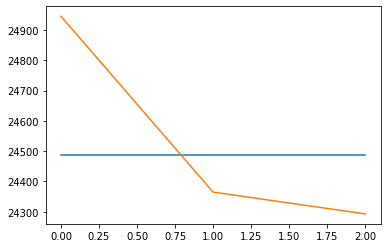

In [140]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [141]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 20ms/step


,Val Predictions,Actuals
0,24486.960938,24021.0


In [143]:
# plt.plot(val_results['Val Predictions'])
# plt.plot(val_results['Actuals'])

In [144]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 17ms/step


,Test Predictions,Actuals
0,24486.960938,23997.0


# SECOND PART

In [145]:
# from sklearn.metrics import mean_squared_error as mse

# def plot_predictions1(model, X, y, start=0, end=100):
#   predictions = model.predict(X).flatten()
#   df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
#   plt.plot(df['Predictions'])
#   plt.plot(df['Actuals'])
#   return df, mse(y, predictions)

In [146]:
# plot_predictions1(model1, X_test1, y_test1)

In [148]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 8)                 2056      
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [151]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1), metrics=[RootMeanSquaredError()])

In [153]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
1/1 [==============================] - 0s 54ms/step - loss: 117377261895680.0000 - root_mean_squared_error: 10834079.0000 - val_loss: 51901794091008.0000 - val_root_mean_squared_error: 7204290.0000
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 44441280708608.0000 - root_mean_squared_error: 6666429.5000

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 559ms/step - loss: 44441280708608.0000 - root_mean_squared_error: 6666429.5000 - val_loss: 8452560650240.0000 - val_root_mean_squared_error: 2907328.7500
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 7265199325184.0000 - root_mean_squared_error: 2695403.2500

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 497ms/step - loss: 7265199325184.0000 - root_mean_squared_error: 2695403.2500 - val_loss: 2029831061504.0000 - val_root_mean_squared_error: 1424721.3750
Epoch 4/100
1/1 [==============================] - 0s 22ms/step - loss: 1723792883712.0000 - root_mean_squared_error: 1312932.8750 - val_loss: 26780215803904.0000 - val_root_mean_squared_error: 5174960.5000
Epoch 5/100
1/1 [==============================] - 0s 24ms/step - loss: 22914415984640.0000 - root_mean_squared_error: 4786900.5000 - val_loss: 165954214428672.0000 - val_root_mean_squared_error: 12882322.0000
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 142118873989120.0000 - root_mean_squared_error: 11921362.0000 - val_loss: 191954369380352.0000 - val_root_mean_squared_error: 13854760.0000
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 164260000825344.0000 - root_mean_squared_error: 12816396.0000 - val_loss: 2483545964544.0000 - val_root_

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 557ms/step - loss: 14614315139072.0000 - root_mean_squared_error: 3822867.5000 - val_loss: 1632150880256.0000 - val_root_mean_squared_error: 1277556.6250
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 1391103836160.0000 - root_mean_squared_error: 1179450.6250

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 490ms/step - loss: 1391103836160.0000 - root_mean_squared_error: 1179450.6250 - val_loss: 809307734016.0000 - val_root_mean_squared_error: 899615.3125
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 697943261184.0000 - root_mean_squared_error: 835430.0000

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 486ms/step - loss: 697943261184.0000 - root_mean_squared_error: 835430.0000 - val_loss: 156296413184.0000 - val_root_mean_squared_error: 395343.4062
Epoch 12/100
1/1 [==============================] - 0s 21ms/step - loss: 136316690432.0000 - root_mean_squared_error: 369210.9062 - val_loss: 1701292015616.0000 - val_root_mean_squared_error: 1304335.8750
Epoch 13/100
1/1 [==============================] - 0s 22ms/step - loss: 1464989253632.0000 - root_mean_squared_error: 1210367.3750 - val_loss: 4906443341824.0000 - val_root_mean_squared_error: 2215049.2500
Epoch 14/100
1/1 [==============================] - 0s 22ms/step - loss: 4216027086848.0000 - root_mean_squared_error: 2053296.6250 - val_loss: 9803641389056.0000 - val_root_mean_squared_error: 3131076.7500
Epoch 15/100
1/1 [==============================] - 0s 21ms/step - loss: 8416785334272.0000 - root_mean_squared_error: 2901169.7500 - val_loss: 2475383324672.0000 - val_root_mean_squared_err

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 507ms/step - loss: 9420980355072.0000 - root_mean_squared_error: 3069361.5000 - val_loss: 60852842496.0000 - val_root_mean_squared_error: 246683.6875
Epoch 27/100
1/1 [==============================] - 0s 21ms/step - loss: 53352280064.0000 - root_mean_squared_error: 230981.1250 - val_loss: 8691862470656.0000 - val_root_mean_squared_error: 2948196.5000
Epoch 28/100
1/1 [==============================] - 0s 22ms/step - loss: 7450748518400.0000 - root_mean_squared_error: 2729606.0000 - val_loss: 8479938969600.0000 - val_root_mean_squared_error: 2912033.5000
Epoch 29/100
1/1 [==============================] - 0s 23ms/step - loss: 7266342273024.0000 - root_mean_squared_error: 2695615.5000 - val_loss: 631761666048.0000 - val_root_mean_squared_error: 794834.3750
Epoch 30/100
1/1 [==============================] - 0s 22ms/step - loss: 542414045184.0000 - root_mean_squared_error: 736487.6250 - val_loss: 2996791934976.0000 - val_root_mean_squared_error: 

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 513ms/step - loss: 565362491392.0000 - root_mean_squared_error: 751905.8750 - val_loss: 21761660928.0000 - val_root_mean_squared_error: 147518.3438
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 18002573312.0000 - root_mean_squared_error: 134173.6719

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 566ms/step - loss: 18002573312.0000 - root_mean_squared_error: 134173.6719 - val_loss: 9914417152.0000 - val_root_mean_squared_error: 99571.1641
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 8067204608.0000 - root_mean_squared_error: 89817.6172

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 483ms/step - loss: 8067204608.0000 - root_mean_squared_error: 89817.6172 - val_loss: 2382243072.0000 - val_root_mean_squared_error: 48808.2266
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 1837208064.0000 - root_mean_squared_error: 42862.6641

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 488ms/step - loss: 1837208064.0000 - root_mean_squared_error: 42862.6641 - val_loss: 35507.9570 - val_root_mean_squared_error: 188.4355
Epoch 41/100
1/1 [==============================] - 0s 20ms/step - loss: 7515659.5000 - root_mean_squared_error: 2741.4702 - val_loss: 576926528.0000 - val_root_mean_squared_error: 24019.2949
Epoch 42/100
1/1 [==============================] - 0s 21ms/step - loss: 601935040.0000 - root_mean_squared_error: 24534.3652 - val_loss: 576925504.0000 - val_root_mean_squared_error: 24019.2734
Epoch 43/100
1/1 [==============================] - 0s 22ms/step - loss: 601934016.0000 - root_mean_squared_error: 24534.3438 - val_loss: 576924544.0000 - val_root_mean_squared_error: 24019.2539
Epoch 44/100
1/1 [==============================] - 0s 23ms/step - loss: 601932992.0000 - root_mean_squared_error: 24534.3223 - val_loss: 576923648.0000 - val_root_mean_squared_error: 24019.2344
Epoch 45/100
1/1 [===========================

In [155]:
model2 = load_model('model2/')
train_predictions2 = model2.predict(X_train1).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train1})
train_results2

1/1 [==============================] - 0s 52ms/step


,Train Predictions,Actuals
0,21066.574219,24945.0
1,21934.482422,24365.0
2,23029.126953,24293.0


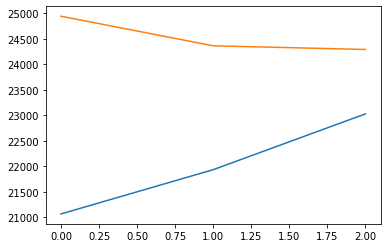

In [157]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])

In [158]:
val_predictions2 = model2.predict(X_val1).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val1})
val_results2

1/1 [==============================] - 0s 19ms/step


,Val Predictions,Actuals
0,23832.564453,24021.0


In [159]:
test_predictions2 = model2.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test1})
test_results2

1/1 [==============================] - 0s 19ms/step


,Test Predictions,Actuals
0,24829.957031,23997.0


# MODEL 3

In [160]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [161]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=1), metrics=[RootMeanSquaredError()])

In [162]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp3])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 602019072.0000 - root_mean_squared_error: 24536.0762

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 602019072.0000 - root_mean_squared_error: 24536.0762 - val_loss: 575021312.0000 - val_root_mean_squared_error: 23979.6016
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 599988992.0000 - root_mean_squared_error: 24494.6719

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 599988992.0000 - root_mean_squared_error: 24494.6719 - val_loss: 570968256.0000 - val_root_mean_squared_error: 23894.9414
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 595849088.0000 - root_mean_squared_error: 24410.0195

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 595849088.0000 - root_mean_squared_error: 24410.0195 - val_loss: 564168192.0000 - val_root_mean_squared_error: 23752.2246
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 588902464.0000 - root_mean_squared_error: 24267.3125

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 588902464.0000 - root_mean_squared_error: 24267.3125 - val_loss: 554494720.0000 - val_root_mean_squared_error: 23547.7109
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 579019072.0000 - root_mean_squared_error: 24062.8145

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 579019072.0000 - root_mean_squared_error: 24062.8145 - val_loss: 541865088.0000 - val_root_mean_squared_error: 23277.9961
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 566112576.0000 - root_mean_squared_error: 23793.1211

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 566112576.0000 - root_mean_squared_error: 23793.1211 - val_loss: 526230688.0000 - val_root_mean_squared_error: 22939.7188
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 550130880.0000 - root_mean_squared_error: 23454.8691

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 550130880.0000 - root_mean_squared_error: 23454.8691 - val_loss: 507579520.0000 - val_root_mean_squared_error: 22529.5254
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 531058528.0000 - root_mean_squared_error: 23044.7070

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 531058528.0000 - root_mean_squared_error: 23044.7070 - val_loss: 485941280.0000 - val_root_mean_squared_error: 22044.0762
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 508921888.0000 - root_mean_squared_error: 22559.2969

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 508921888.0000 - root_mean_squared_error: 22559.2969 - val_loss: 461393248.0000 - val_root_mean_squared_error: 21480.0664
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 483794816.0000 - root_mean_squared_error: 21995.3359

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 483794816.0000 - root_mean_squared_error: 21995.3359 - val_loss: 434066528.0000 - val_root_mean_squared_error: 20834.2637
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 455805088.0000 - root_mean_squared_error: 21349.5918

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 455805088.0000 - root_mean_squared_error: 21349.5918 - val_loss: 404152672.0000 - val_root_mean_squared_error: 20103.5488
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 425141024.0000 - root_mean_squared_error: 20618.9473

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 425141024.0000 - root_mean_squared_error: 20618.9473 - val_loss: 371910464.0000 - val_root_mean_squared_error: 19284.9805
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 392058400.0000 - root_mean_squared_error: 19800.4648

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 392058400.0000 - root_mean_squared_error: 19800.4648 - val_loss: 337672352.0000 - val_root_mean_squared_error: 18375.8633
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 356886944.0000 - root_mean_squared_error: 18891.4512

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 356886944.0000 - root_mean_squared_error: 18891.4512 - val_loss: 301851264.0000 - val_root_mean_squared_error: 17373.8672
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 320037120.0000 - root_mean_squared_error: 17889.5820

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 320037120.0000 - root_mean_squared_error: 17889.5820 - val_loss: 264945872.0000 - val_root_mean_squared_error: 16277.1582
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 282005856.0000 - root_mean_squared_error: 16793.0293

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 282005856.0000 - root_mean_squared_error: 16793.0293 - val_loss: 227545056.0000 - val_root_mean_squared_error: 15084.5967
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 243380656.0000 - root_mean_squared_error: 15600.6621

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 243380656.0000 - root_mean_squared_error: 15600.6621 - val_loss: 190329216.0000 - val_root_mean_squared_error: 13795.9854
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 204841792.0000 - root_mean_squared_error: 14312.2949

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 204841792.0000 - root_mean_squared_error: 14312.2949 - val_loss: 154068368.0000 - val_root_mean_squared_error: 12412.4277
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 167160496.0000 - root_mean_squared_error: 12929.0566

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 167160496.0000 - root_mean_squared_error: 12929.0566 - val_loss: 119613720.0000 - val_root_mean_squared_error: 10936.8057
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 131190912.0000 - root_mean_squared_error: 11453.8604

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 131190912.0000 - root_mean_squared_error: 11453.8604 - val_loss: 87879824.0000 - val_root_mean_squared_error: 9374.4238
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 97852928.0000 - root_mean_squared_error: 9892.0635

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 97852928.0000 - root_mean_squared_error: 9892.0635 - val_loss: 59812640.0000 - val_root_mean_squared_error: 7733.8633
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 68101416.0000 - root_mean_squared_error: 8252.3584

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 68101416.0000 - root_mean_squared_error: 8252.3584 - val_loss: 36338384.0000 - val_root_mean_squared_error: 6028.1328
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 42875940.0000 - root_mean_squared_error: 6547.9722

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 42875940.0000 - root_mean_squared_error: 6547.9722 - val_loss: 18284644.0000 - val_root_mean_squared_error: 4276.0547
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 23023424.0000 - root_mean_squared_error: 4798.2729

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 23023424.0000 - root_mean_squared_error: 4798.2729 - val_loss: 6269360.5000 - val_root_mean_squared_error: 2503.8691
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 9188687.0000 - root_mean_squared_error: 3031.2847

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 9188687.0000 - root_mean_squared_error: 3031.2847 - val_loss: 557574.3125 - val_root_mean_squared_error: 746.7090
Epoch 26/100
1/1 [==============================] - 0s 24ms/step - loss: 1672894.1250 - root_mean_squared_error: 1293.4041 - val_loss: 903725.0000 - val_root_mean_squared_error: 950.6445
Epoch 27/100
1/1 [==============================] - 0s 24ms/step - loss: 276426.9062 - root_mean_squared_error: 525.7632 - val_loss: 6425215.0000 - val_root_mean_squared_error: 2534.8008
Epoch 28/100
1/1 [==============================] - 0s 23ms/step - loss: 4171518.0000 - root_mean_squared_error: 2042.4294 - val_loss: 15584206.0000 - val_root_mean_squared_error: 3947.6836
Epoch 29/100
1/1 [==============================] - 0s 29ms/step - loss: 11879949.0000 - root_mean_squared_error: 3446.7302 - val_loss: 26354186.0000 - val_root_mean_squared_error: 5133.6328
Epoch 30/100
1/1 [==============================] - 0s 28ms/step - loss: 

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 223752.2969 - root_mean_squared_error: 473.0246 - val_loss: 29251.6875 - val_root_mean_squared_error: 171.0312
Epoch 44/100
1/1 [==============================] - 0s 24ms/step - loss: 202358.2656 - root_mean_squared_error: 449.8425 - val_loss: 210869.2969 - val_root_mean_squared_error: 459.2051
Epoch 45/100
1/1 [==============================] - 0s 25ms/step - loss: 1031018.5000 - root_mean_squared_error: 1015.3908 - val_loss: 990297.0625 - val_root_mean_squared_error: 995.1367
Epoch 46/100
1/1 [==============================] - 0s 24ms/step - loss: 2360681.2500 - root_mean_squared_error: 1536.4508 - val_loss: 2047744.2500 - val_root_mean_squared_error: 1430.9941
Epoch 47/100
1/1 [==============================] - 0s 23ms/step - loss: 3865581.7500 - root_mean_squared_error: 1966.1083 - val_loss: 3113963.5000 - val_root_mean_squared_error: 1764.6426
Epoch 48/100
1/1 [==============================] - 0s 27ms/step - loss: 5274371.

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 680591.6875 - root_mean_squared_error: 824.9798 - val_loss: 8879.3809 - val_root_mean_squared_error: 94.2305
Epoch 60/100
1/1 [==============================] - 0s 24ms/step - loss: 260833.1250 - root_mean_squared_error: 510.7182 - val_loss: 186273.1719 - val_root_mean_squared_error: 431.5938
Epoch 61/100
1/1 [==============================] - 0s 24ms/step - loss: 91868.2734 - root_mean_squared_error: 303.0978 - val_loss: 551784.9375 - val_root_mean_squared_error: 742.8223
Epoch 62/100
1/1 [==============================] - 0s 23ms/step - loss: 137852.7344 - root_mean_squared_error: 371.2852 - val_loss: 1036868.8750 - val_root_mean_squared_error: 1018.2676
Epoch 63/100
1/1 [==============================] - 0s 25ms/step - loss: 340146.1562 - root_mean_squared_error: 583.2205 - val_loss: 1562700.2500 - val_root_mean_squared_error: 1250.0801
Epoch 64/100
1/1 [==============================] - 0s 24ms/step - loss: 627977.5625 - roo

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 223469.3750 - root_mean_squared_error: 472.7255 - val_loss: 4502.3574 - val_root_mean_squared_error: 67.0996
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 284310.3438 - root_mean_squared_error: 533.2076

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 284310.3438 - root_mean_squared_error: 533.2076 - val_loss: 340.0134 - val_root_mean_squared_error: 18.4395
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 330105.5625 - root_mean_squared_error: 574.5482

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 330105.5625 - root_mean_squared_error: 574.5482 - val_loss: 23.6515 - val_root_mean_squared_error: 4.8633
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 353711.2500 - root_mean_squared_error: 594.7363

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 353711.2500 - root_mean_squared_error: 594.7363 - val_loss: 16.9995 - val_root_mean_squared_error: 4.1230
Epoch 84/100
1/1 [==============================] - 0s 23ms/step - loss: 352948.6562 - root_mean_squared_error: 594.0948 - val_loss: 341.7443 - val_root_mean_squared_error: 18.4863
Epoch 85/100
1/1 [==============================] - 0s 24ms/step - loss: 330063.0625 - root_mean_squared_error: 574.5112 - val_loss: 3612.6675 - val_root_mean_squared_error: 60.1055
Epoch 86/100
1/1 [==============================] - 0s 24ms/step - loss: 290603.0312 - root_mean_squared_error: 539.0761 - val_loss: 13769.0977 - val_root_mean_squared_error: 117.3418
Epoch 87/100
1/1 [==============================] - 0s 23ms/step - loss: 241996.8594 - root_mean_squared_error: 491.9318 - val_loss: 34754.5703 - val_root_mean_squared_error: 186.4258
Epoch 88/100
1/1 [==============================] - 0s 25ms/step - loss: 192056.1094 - root_mean_squared_

In [163]:
model3 = load_model('model3/')
train_predictions3 = model3.predict(X_train1).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train1})
train_results3

1/1 [==============================] - 0s 332ms/step


,Train Predictions,Actuals
0,24016.876953,24945.0
1,24016.876953,24365.0
2,24016.876953,24293.0


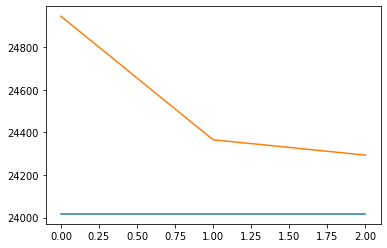

In [164]:
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])

In [165]:
val_predictions3 = model3.predict(X_val1).flatten()
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val1})
val_results3

1/1 [==============================] - 0s 17ms/step


,Val Predictions,Actuals
0,24016.876953,24021.0


In [166]:
test_predictions3 = model3.predict(X_test1).flatten()
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test1})
test_results3

1/1 [==============================] - 0s 17ms/step


,Test Predictions,Actuals
0,24016.876953,23997.0


# Multi-variate Dataset

In [188]:
def df_to_X_y2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [189]:
X2, y2 = df_to_X_y2(lstm_data)
X2.shape, y2.shape

((5, 5, 2), (5,))

In [207]:
X_train2, y_train2 = X2[:3], y2[:3]
X_val2, y_val2 = X2[3:4], y2[3:4]
X_test2, y_test2 = X2[4:], y2[4:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((3, 5, 2), (3,), (1, 5, 2), (1,), (1, 5, 2), (1,))

In [216]:
loss_training_mean = np.mean(X_train2[:, :, 1])
loss_training_std = np.std(X_train2[:, :, 1])
                           
def preprocess_loss(X):
  X[:, :, 1] = (X[:, :, 1] - loss_training_mean) / loss_training_std
  return X

pop_training_mean = np.mean(X_train2[:, :, 0])
pop_training_std = np.std(X_train2[:, :, 0])
                           
def preprocess_pop(X):
  X[:, :, 0] = (X[:, :, 0] - pop_training_mean) / pop_training_std
  return X

In [217]:
preprocess_loss(X_train2)
preprocess_loss(X_val2)
preprocess_loss(X_test2)
preprocess_pop(X_train2)
preprocess_pop(X_val2)
preprocess_pop(X_test2)

array([[[0.623260540619076, 0.08770839493819478],
        [1.2213222394730898, 1.878454411518965],
        [1.8041978462663328, 1.5344223844845672],
        [2.36886604425373, 1.4917149604389177],
        [2.9057063248522814, 1.3303758029331314]]], dtype=object)

In [218]:
X_train2

array([[[-1.8548552570254198, -1.640162802908703],
        [-1.2329410575523947, -1.0689510062981427],
        [-0.6096752163776257, -0.3992748709156682],
        [0.011046358064448814, -0.19285565469502958],
        [0.623260540619076, 0.08770839493819478]],

       [[-1.2329410575523947, -1.0689510062981427],
        [-0.6096752163776257, -0.3992748709156682],
        [0.011046358064448814, -0.19285565469502958],
        [0.623260540619076, 0.08770839493819478],
        [1.2213222394730898, 1.878454411518965]],

       [[-0.6096752163776257, -0.3992748709156682],
        [0.011046358064448814, -0.19285565469502958],
        [0.623260540619076, 0.08770839493819478],
        [1.2213222394730898, 1.878454411518965],
        [1.8041978462663328, 1.5344223844845672]]], dtype=object)

# MODEL 4

In [219]:
model4 = Sequential()
model4.add(InputLayer((5, 2)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                17152     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [220]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])



In [221]:
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp4])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [199]:
X_train2["Actual Loss"] = np.asarray(X_train2["Actual Loss"]).astype('float64')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
grid_search.best_params_


In [ ]:
my_model=grid_search.best_estimator_.model

In [ ]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

In [ ]:
scaler.inverse_transform(prediction)

In [ ]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [ ]:
prediction_copies_array.shape

In [ ]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [ ]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "year", "loss_percentage", "activity", "food_supply_stage", "cause_of_loss"]]

def focus_on(country, commodity):
    new_df = df[df.country == country]
    new_df = new_df[new_df.commodity == commodity]
    return new_df

# data = focus_on("Kenya", "Maize (corn)")
data = focus_on("Benin", "Maize (corn)")
data = data.reset_index()
data.sort_values(by=(["index"]), ascending=False, inplace=True)
data

In [ ]:
validate = data[["activity","food_supply_stage","loss_percentage"]].tail(3)
data.drop(data.tail(3).index,inplace=True)

In [ ]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]])
Y_data = Y_scaler.fit_transform(data[['loss_percentage']])

In [ ]:
X_data

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [ ]:
hist_window = 8
horizon = 3
TRAIN_SPLIT = 120
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True),
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     # tf.keras.layers.Dense(30, activation='tanh'),
     # tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.15),
     tf.keras.layers.Dense(units=horizon),
    ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:

data_val

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate["loss_percentage"],pred_Inverse[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['loss_percentage']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Loss Percentage")
plt.xlabel('Years (After 2000)')
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [ ]:
validate["loss_percentage"]

In [ ]:
pred_Inverse[0]

TUNING

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
    lstm_model_opt = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                    input_shape=x_train.shape[-2:]),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Dense(units=horizon),
        ])
    lstm_model_opt.compile(optimizer=hparams[HP_OPTIMIZER], loss='mse')
    lstm_model_opt.summary()
    model_path = 'Bidirectional_LSTM_Multivariate_opt.h5'
    early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')
    checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    callbacks=[early_stopings,checkpoint]
    history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)
    (validate["loss_percentage"], pred_Inverse[0])
    return history

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    history = train_test_model(hparams)
    accuracy=model.evaluate(x_test, y_test)
    tf.summary.scalar(METRIC_ACCURACY, step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
data_val = X_scaler.fit_transform(data[["activity", "food_supply_stage", "loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')


timeseries_evaluation_metrics_func(validate["loss_percentage"], pred_Inverse[0])
plt.figure(figsize=(16, 9))
plt.plot(list(validate['loss_percentage']))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual', 'predicted'))
plt.show()